## BeatGAN_adb: Try different data with Anomalous Rhythm Detection using Adversarially Generated Time

### Abstract
Given a large-scale rhythmic time series containing mostly normal data segments (or ‘beats’), can we learn how to detect anomalous beats in an effective yet efficient way? For example, how can we detect anomalous beats from electrocardiogram (ECG) readings? Existing approaches either require excessively high amounts of labeled and balanced data for classification, or rely on less regularized reconstructions, resulting in lower accuracy in anomaly detection. Therefore, we propose BeatGAN, an unsupervised anomaly detection algorithm for time series data. BeatGAN outputs explainable results to pinpoint the anomalous time ticks of an input beat, by comparing them to adversarially generated beats. Its robustness is guaranteed by its regularization of reconstruction error using an adversarial generation approach, as well as data augmentation using time series warping. Experiments show that BeatGAN accurately and efficiently detects anomalous beats in ECG time series, and routes doctors’ attention to anomalous time ticks, achieving accuracy of nearly 0.95 AUC, 
and very fast inference (2.6 ms per beat). In addition, we show that BeatGAN accurately detects unusual motions from multivariate motion-capture time series data, illustrating its generality.

You can configure the backend to use GPU or CPU only. \
Default is using backend cpu. 

In [2]:
import sys
sys.path.append("C:/Users/bailean/Documents/Bitbucket-Projects/spartan2")

import spartan as st
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

```loadTensor``` function automatically read data from file and ```toDTensor``` function extract time and value separately from the tensor.<br/>```Timeseries``` class is designed to construct time tensor.

labels=Index(['IB5Value', 'ESCBiasVoltage_AI V', 'TCPRFGenForwardPower_AI watt',
       'CurrentMMPPhase', 'BiasRFGenForwardPower_AI watt',
       'TCPMatchCurrentPhaseDifference_AI deg'],
      dtype='object'), code doesn't want time label which must be firt usecols index


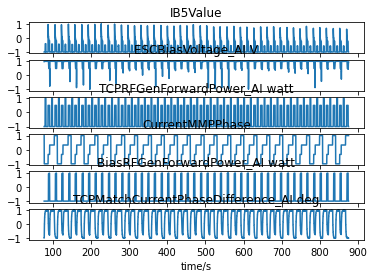

In [3]:
subset = 'inputData/LRCX-1/05-01-23_DataSUBset3_SJSUcase.csv'
LRCXfilepath = subset
pulse_AO = 60
kwargs = {
        'header': 0,
        'usecols': [0,13,67,8,61,36, pulse_AO] 
                    #36, 38, 120, 77 ] # of interest for full dataset3
                    #60, 13,  67, 8 ] # corresponding for SUBset of dataset3  
                    #OES in subset [0,8,18,20,22,23,25,26,28,30,31,32,33]
        }
df = pd.read_csv(LRCXfilepath)
if not kwargs['usecols'] is None: 
        sorted_cols = sorted(kwargs['usecols'][1:])
        pulse_AO_idx = sorted_cols.index(pulse_AO)
        labels = df.columns[sorted_cols]
        time, value = st.loadTensor(path = LRCXfilepath, col_types = [float]*(len(labels)+1), sep=',', **kwargs).toDTensor(hastticks=True)
else:
        kwargs.pop('usecols') 
        labels = df.columns[1:]
        time, value = st.loadTensor(path = LRCXfilepath, col_types = [float]*(len(labels)+1), sep=',', **{'header': 0}).toDTensor(hastticks=True)

print(f"{labels=}, code doesn't want time label which must be firt usecols index")
time_series = st.Timeseries(value, time, labels = labels).cut(start=767, end=8756, inplace=False).normalize(inplace=False)
num_sigs = len(time_series.val_tensor[:,0])

st.plot_timeseries(time_series)
# time, value = st.loadTensor(path = "inputData/ecg_timeseries_small.zip", col_types = [float, float], sep=' ').toDTensor(hastticks=True)
# time_series = st.Timeseries(value, time)


### Run RPeak to segment ECG series data.

This example use ECG series data as example. Before we train the model, we need RPeak to preprocess data.<br/>
THEY USE biosppy.ecg.ecg to locate the beats and then partition out a preceding and following array per the function parameters below
Default parameters are:<br/>
{'sampling_rate': 360, 'left_size': 120, 'right_size': 136, 'out_path': None}

In [3]:
if False:
    rpeak = st.RPeak(time_series)
    segments = rpeak.run()
    segments.shape

adb: I'll just write a bit of specific 'beat' finding with zero padding to enable the code to utilize its syntetic generalized DTW code


len 344 seg_starts[-1]=345 seg_starts[-2]=1
len 362 seg_starts[-1]=707 seg_starts[-2]=345
len 340 seg_starts[-1]=1047 seg_starts[-2]=707
len 362 seg_starts[-1]=1409 seg_starts[-2]=1047
len 340 seg_starts[-1]=1749 seg_starts[-2]=1409
len 364 seg_starts[-1]=2113 seg_starts[-2]=1749
len 338 seg_starts[-1]=2451 seg_starts[-2]=2113
len 364 seg_starts[-1]=2815 seg_starts[-2]=2451
len 338 seg_starts[-1]=3153 seg_starts[-2]=2815
len 344 seg_starts[-1]=3497 seg_starts[-2]=3153
len 338 seg_starts[-1]=3835 seg_starts[-2]=3497
len 362 seg_starts[-1]=4197 seg_starts[-2]=3835
len 340 seg_starts[-1]=4537 seg_starts[-2]=4197
len 360 seg_starts[-1]=4897 seg_starts[-2]=4537
len 342 seg_starts[-1]=5239 seg_starts[-2]=4897
len 344 seg_starts[-1]=5583 seg_starts[-2]=5239
len 338 seg_starts[-1]=5921 seg_starts[-2]=5583
len 340 seg_starts[-1]=6261 seg_starts[-2]=5921
len 344 seg_starts[-1]=6605 seg_starts[-2]=6261
len 362 seg_starts[-1]=6967 seg_starts[-2]=6605
len 340 seg_starts[-1]=7307 seg_starts[-2]=6967

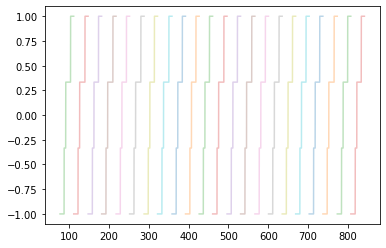

In [4]:
known_pulse_AO = time_series.val_tensor[pulse_AO_idx,:]
seg_starts = []
for seg_idx in range(1, len(known_pulse_AO)):
    if (known_pulse_AO[seg_idx-1] > 0.95) and (known_pulse_AO[seg_idx] < -0.95):
        seg_starts.append(seg_idx)
        if len(seg_starts) > 1:
            print(f"len {seg_starts[-1]-seg_starts[-2]} {seg_starts[-1]=} {seg_starts[-2]=}")
            plt.plot(time_series.time_tensor[seg_starts[-2]:seg_starts[-1]], known_pulse_AO[seg_starts[-2]:seg_starts[-1]], markeredgecolor='none', alpha=0.3, color='C'+str(len(seg_starts)), label=seg_idx)
#plt.legend()
print(f"{max(np.subtract(seg_starts[1:],seg_starts[0:-1]))=}")
print(f"{min(np.subtract(seg_starts[1:],seg_starts[0:-1]))=}")

In [5]:
time_series.length

7989

21

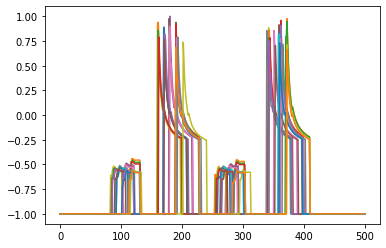

In [24]:
# data_extend will extend the data capture for each pulse both ends
# data_pad_to will further expand the training space for training balanced both ends
plt.close()
left_data_extend = 13
right_data_extend = -11
data_pad_to = 500

segments = []
for cnt, seg_idx in enumerate(seg_starts[:-1]):
    if seg_idx-left_data_extend >= 0 and seg_idx + right_data_extend < time_series.length:
        raw_segment = np.array(time_series.val_tensor[:, seg_idx - left_data_extend: seg_starts[cnt+1] + right_data_extend])
        raw_segment_len = len(raw_segment[0])
        left_pad_len = int((data_pad_to - raw_segment_len)/2)
        right_pad_len = data_pad_to - raw_segment_len - left_pad_len
        # print(f"{left_pad_len=} {right_pad_len=} {}")
        left_pad_segment = np.repeat(np.array(time_series.val_tensor[:, seg_idx - left_data_extend]).reshape(num_sigs,1),left_pad_len, axis=1)
        right_pad_segment = np.repeat(np.array(time_series.val_tensor[:, seg_idx + right_data_extend]).reshape(num_sigs,1),right_pad_len, axis=1)  
        
        padded_segment = np.concatenate((left_pad_segment,raw_segment,right_pad_segment), axis = 1)
        segments.append(padded_segment)
        #segments.append(raw_segment)

        # print(f"{np.shape(segments)=} {np.shape(left_pad_segment) =} {np.shape(raw_segment)=} {np.shape(right_pad_segment) =} {np.shape(padded_segment)=}")
        
        # print(f"{np.shape(segments[-1][plot_signal][:])=} {np.shape(np.arange(len(segments[-1][plot_signal])))=}")
        # would have to move to ax.plt to make this look good
        plot_signal = 0
        plt.plot(np.arange(len(segments[-1][plot_signal])), segments[-1][plot_signal][:], markeredgecolor='none', alpha=1, color='C'+str(cnt), label=cnt)
        
        if False:
            for plot_signal in range(min(1,num_sigs)):
                plt.plot(np.arange(len(segments[-1][plot_signal])), segments[-1][plot_signal][:], markeredgecolor='none', alpha=1, color='C'+str(cnt), label=cnt)
                # plt.title(time_series.labels[plot_signal])
                #plt.show()
    
segments = st.DTensor.from_numpy(np.array(segments))
len(segments)

### Run BeatGAN as a single model

BeatGAN has two kinds of structure, CNN and RNN which is controled by parameter ```network```.

Default parameters are: <br/>
{'seq_len': 256, 'stride': 32, 'input_size': 1, 'rep_size': 20, 'batch_size': 64, 'max_epoch':5, 'lr': 0.01, 'lambda': 1
'net_type':'gru', 'layers':1, 'hidden_size':100} <br/>
You can change them be passing <key>=<value> as the doc shows.

In [16]:
beatgan_CNN = st.BeatGAN(segments, "my_beatgan_model", network="CNN", seq_len=data_pad_to)

[Conv1d(1, 32, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(32, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(512, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), Ba

C:\Users/bailean/Documents/Bitbucket-Projects/spartan2\spartan\model\beatgan\preprocess.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  self.data = torch.Tensor(segments)


In [23]:
trained_model = beatgan_CNN.fit()

100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


ValueError: need at least one array to concatenate

### Use PipeLine to finish the work mentioned above.

In [29]:
rpeak_params = {'sampling_rate': 360, 'left_size': 120, 'right_size': 136}

beatgan_params = {'network': 'CNN', 'seq_len': 256, 'stride': 32, 'input_size': 1, 'rep_size': 20, 'model_name': 'my_beatgan_model'}
pipeline = st.PipeLine(time_series, [(st.RPeak, rpeak_params), ((st.Train, st.TrainPolicy.BeatGAN), beatgan_params)])

We will get a trained model after calling ```run``` function of ```pipeline```.

In [30]:
pipeline.run()

[Conv1d(1, 32, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(32, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(512, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), Ba

100%|██████████| 5/5 [00:00<00:00, 33.92it/s]


### Save and load trained models

Function ```save_model_to``` saves model to assigned path.

In [18]:
trained_model.save_model_to(path='./trained_model/adb_test_cnn.pth')

Parameter ```model_path``` loads model from assigned path.

In [19]:
beatgan_CNN = st.BeatGAN(segments, "my_beatgan_model", network="CNN", model_path="./trained_model/adb_test_cnn.pth")
rec_diff, ori_ts, rec_ts, rec_err = beatgan_CNN.predict()

[Conv1d(1, 32, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(32, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(512, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), Ba

RuntimeError: Error(s) in loading state_dict for Generator:
	Unexpected key(s) in state_dict: "encoder.18.weight", "encoder.18.bias", "encoder.18.running_mean", "encoder.18.running_var", "encoder.18.num_batches_tracked", "encoder.20.weight", "decoder.21.weight", "decoder.19.weight", "decoder.19.bias", "decoder.19.running_mean", "decoder.19.running_var", "decoder.19.num_batches_tracked". 
	size mismatch for encoder.17.weight: copying a param with shape torch.Size([2048, 1024, 4]) from checkpoint, the shape in current model is torch.Size([20, 1024, 4]).
	size mismatch for decoder.0.weight: copying a param with shape torch.Size([20, 2048, 4]) from checkpoint, the shape in current model is torch.Size([20, 1024, 4]).
	size mismatch for decoder.1.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for decoder.1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for decoder.1.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for decoder.1.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for decoder.3.weight: copying a param with shape torch.Size([2048, 1024, 4]) from checkpoint, the shape in current model is torch.Size([1024, 512, 4]).
	size mismatch for decoder.4.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for decoder.4.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for decoder.4.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for decoder.4.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for decoder.6.weight: copying a param with shape torch.Size([1024, 512, 4]) from checkpoint, the shape in current model is torch.Size([512, 256, 4]).
	size mismatch for decoder.7.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for decoder.7.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for decoder.7.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for decoder.7.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for decoder.9.weight: copying a param with shape torch.Size([512, 256, 4]) from checkpoint, the shape in current model is torch.Size([256, 128, 4]).
	size mismatch for decoder.10.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for decoder.10.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for decoder.10.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for decoder.10.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for decoder.12.weight: copying a param with shape torch.Size([256, 128, 4]) from checkpoint, the shape in current model is torch.Size([128, 64, 4]).
	size mismatch for decoder.13.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.13.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.13.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.13.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.15.weight: copying a param with shape torch.Size([128, 64, 4]) from checkpoint, the shape in current model is torch.Size([64, 32, 4]).
	size mismatch for decoder.16.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for decoder.16.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for decoder.16.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for decoder.16.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for decoder.18.weight: copying a param with shape torch.Size([64, 32, 4]) from checkpoint, the shape in current model is torch.Size([32, 1, 4]).

Sort by max window reconstruction error and get the sorted indices.

In [20]:
import numpy as np
new_score=[]
window_size=32
for scores in rec_err:
    tmp_score=0
    for i in range(0,len(scores),window_size):
        tmp_score=max(tmp_score, np.mean(scores[i:i+window_size]))
    new_score.append(tmp_score)
ind=np.argsort(new_score)

NameError: name 'rec_err' is not defined

Draw plots of segments which deviate the least and the most with ```st.plot```.

In [21]:
st.plot(st.BeatGAN, ori_ts[ind[0]], rec_ts[ind[0]], rec_err)
st.plot(st.BeatGAN, ori_ts[ind[-1]], rec_ts[ind[-1]], rec_err)

NameError: name 'ori_ts' is not defined

Deviate the least | Deviate the most
:-------------------------:|:-------------------------:
<img src="images/beatganRec1.png" width="300"/>  |   <img src="images/beatganRec2.png" width="300"/>
<b>Segment with maximum reconstruction error. |  <b>Segment with minimum reconstruction error.

### Run BeatGAN from train task to get a trained model

In [ ]:
train_task = st.Train.create(segments, st.TrainPolicy.BeatGAN, 'my_beatgan_model', network='CNN')

In [ ]:
train_task.run()

### Experiment Results
------
BeatGAN Structure      |  BeatGAN on Motion Datasets
:-------------------------:|:-------------------------:
<img src="images/beatganExp1.png" width="300"/>  |   <img src="images/beatganExp2.png" width="300"/>
<b>Structure of BeatGAN. |  <b>Beatlex reconstructs motion data.

|BeatGAN's fast inference|
|:-------------------------:|
|<img src="images/beatganExp3.png" width="300"/>|
|<b>BeatGAN has fast inference.|

### Cite:
------
1. Zhou, B., Liu, S., Hooi, B., Cheng, X., & Ye, J. (2019, August). BeatGAN: Anomalous Rhythm Detection using Adversarially Generated Time Series. In IJCAI (pp. 4433-4439).

    <details>
    <summary><span style="color:blue">click for BibTex...</span></summary>

    ```bibtex
    @inproceedings{zhou2019beatgan,
      title={BeatGAN: Anomalous Rhythm Detection using Adversarially Generated Time Series.},
      author={Zhou, Bin and Liu, Shenghua and Hooi, Bryan and Cheng, Xueqi and Ye, Jing},
      booktitle={IJCAI},
      pages={4433--4439},
      year={2019}
    }
    ```
    </details>